# Machine Learning for Economics
## Project 2
##          
#### Ramon Gmür 16-705-220
#### Ben Murphy 16-714-925
#### Florian Rüegsegger 14-714-737
### 
#### 1 Data Preprocessing
#### 2 Model training & evaluation

In [5]:
import pandas as pd
from sklearn.linear_model import Ridge, LinearRegression,Lasso
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

%matplotlib inline


##  1 Data Preprocessing


#### 1.1 Read and Merge Data

In [124]:
#HFI
df2 = pd.read_excel('human-freedom-index-2019-data-tables-figures.xlsx',engine='openpyxl')
df2.columns=df2.iloc[3]
df2.drop([0,1,2,3],inplace=True)
df2.reset_index(inplace=True,drop=True)
#last three cols are Nan
df2 = df2[df2.columns[:-3]]

#nans are encoded with '-'
df2.replace('-',np.nan,inplace=True)
df2.rename(columns={'Countries':'Country'}, inplace=True)

year_range = [2010,2018]
countries = np.unique(df2['Country'])

#Setup merge df 
df = pd.DataFrame(columns=['Year','Country','Region'])

# Create a df with countries,years and region for the years 2010 - 2018
for year in range(year_range[0],year_range[1]+1):
    for country in countries:
        reg = df2.loc[df2['Country']==country,'Region'].to_numpy()
        
        df=df.append({'Country':country,'Year':year,'Region':reg[0]}, ignore_index=True)

df = pd.merge(df,df2,how='left',on=['Country','Year','Region'])
print(np.sum(df.loc[df['Year']==2018,'Region'].isnull()))

#GDP data
df3 = pd.read_csv('GDP.csv')
df3 = df3.melt(id_vars=['Country ','Country Code'],var_name='Year', value_name='GDP')
df3['Year'] = df3['Year'].astype(np.int64)
df3 = df3[df3['Year'].isin([x for x in range(2010,2019)])]
df3.reset_index(drop=True, inplace=True)
df3.rename(columns = {'Country ':'Country'}, inplace = True) 

countries2 = np.unique(df3['Country'])
#Right join since we need GDP
df = pd.merge(df3,df,how='inner',on=['Country','Year'])
#Only years 2010 to 2018 (2018 only for GDP) are interesting
df = df[df['Year'].isin([x for x in range(2010,2019)])]


0


#### 1.2 Preprocessing

In [144]:
print(np.sum(df['Region'].isnull()))
#Drop Rank and Quartiles
df.drop(df[["HUMAN FREEDOM (Rank)","HUMAN FREEDOM (Quartile)","PERSONAL FREEDOM (Rank)","ECONOMIC FREEDOM (Rank)"]], inplace=True, axis=1)

#Drop DATA columns
for i in df.columns:
    if 'DATA' in i:
        df.drop(i,axis=1,inplace=True)
        
#Drop ISO Code
df.drop('ISO Code',axis=1,inplace=True)
df.drop('Country Code',axis=1,inplace=True)
#One Hot encode Region
ohe = OneHotEncoder(sparse=False)
f = ohe.fit_transform(df['Region'].to_numpy().reshape(-1,1))
categories = ohe.categories_[0]
for i in range(categories.size):
    df[categories[i]] = f[:,i]
    


#impute nan's with median's per region and year
for year in df['Year'].unique():
    for region in df["Region"].unique():
        median = df.loc[(df['Region']==region) & (df['Year']<=year)].median(axis=0)
        df.loc[(df['Region']==region) & (df['Year']==year)].fillna(value=median,inplace=True)
     

df.replace(' ',np.nan,inplace=True)

#Drop cols with more than 100 NaN
badCols = []
for column in df.columns:
    if np.sum(df.loc[df['Year']<2018,column].isnull())>100:
        #Safety to keep the GDP col
        if column!='GDP':
            badCols.append(column)
df.drop(badCols,axis=1,inplace=True)

print(np.sum(df['GDP'].isnull()))
#Lag GDP by one year to be used as the dependent varb
df['GDP_next'] = np.nan
for c in np.unique(df['Country']):
    ind = df.loc[df['Country']==c,'GDP'].index
    for i in range(len(ind)-1):
        df.at[ind[i],'GDP_next'] = df.at[ind[i+1],'GDP']
    df.loc[df['Country']==c,['GDP','GDP_next']]



#Drop rows with nans 
df.dropna(axis=0,inplace=True) 

#Country and Region are not needed anymore
df.drop(['Country','Region'],axis=1,inplace=True)
    

df.reset_index(inplace=True,drop=True)


#Define X and y
X = df.loc[df['Year']!=2018, df.columns != 'GDP_next'].to_numpy(dtype=np.float64)
y = np.log(df.loc[df['Year']!=2018,'GDP_next']).to_numpy(dtype=np.float64)
print(X.shape)
print(y.shape)

0


C:\Users\Flo\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


0
(890, 97)
(890,)


In [189]:
X.shape

(890, 97)

In [160]:
Xtrain = df.loc[df['Year']<2017, df.columns != 'GDP_next'].to_numpy(dtype=np.float64)
Xtest = df.loc[df['Year']==2017, df.columns != 'GDP_next'].to_numpy(dtype=np.float64)

ytrain = np.log(df.loc[df['Year']<2017,'GDP_next']).to_numpy(dtype=np.float64)
ytest = np.log(df.loc[df['Year']==2017,'GDP_next']).to_numpy(dtype=np.float64)

print(Xtrain.shape)
print(Xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(779, 97)
(111, 97)
(779,)
(111,)


## 2 Model training & evaluation

In [162]:
from sklearn.model_selection import KFold
def kfold_validation(X,y,model):
    start = time.time()
    kf = KFold(n_splits=5,shuffle=True) 
    mses = []
    models = []
    count = 0
    for trainIndices,testIndices in kf.split(X):
        #print(f"iteration: {count}")
        Xtrain,Xval = X[trainIndices,:],X[testIndices,:]
        ytrain,yval = y[trainIndices],y[testIndices]
        model.fit(Xtrain,ytrain)
        yhat = model.predict(Xval)
        mse = np.sum(np.square(yval-yhat))/yval.size
        mses.append(mse)
        models.append(model)
        count+=1
    #print(f"time used (seconds): {time.time()-start}")
    return mses, models


In [163]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#Xtrain,Xtest, ytrain,ytest = train_test_split(X,y,shuffle=True,train_size=0.8)

def standardise_data(X):
    mean = np.mean(X)
    std = np.std(X)
    X_std = (X-mean)/std
    return X_std, mean, std


Xtrain_std, X_train_mean, X_train_std_div = standardise_data(Xtrain)

Xtest_std = (Xtest-X_train_mean)/X_train_std_div


### Linear Regression

#### Quadratic features
Here we expanded each feature with its quadratic counterpart

In [182]:
from sklearn.preprocessing import FunctionTransformer
model = LinearRegression()
Xtrain_std_poly = Xtrain_std
Xtest_std_poly = Xtest_std

def QuadraticFeatures(X):
    # returns for each column x {x,x^2}
    newX = np.empty(shape=(X.shape[0],X.shape[1]*2))
    for i in range(X.shape[1]):
        newX[:,i] = X[:,i]
        newX[:,i+X.shape[1]] = np.square(X[:,i])
    return newX


transformer = FunctionTransformer(QuadraticFeatures, validate=True)
print(Xtest.shape)
Xtrain_std_poly = transformer.transform(Xtrain_std_poly)
Xtest_std_poly = transformer.transform(Xtest_std_poly)
print(Xtest_std_poly.shape)

Xtrain_std_poly, X_train_mean, X_train_std_div = standardise_data(Xtrain_std_poly)

Xtest_std_poly = (Xtest_std_poly-X_train_mean)/X_train_std_div

model.fit(Xtrain_std_poly,ytrain)
mses,models = kfold_validation(Xtrain_std_poly,ytrain,model)
yhat=models[np.argmin(mses)].predict(Xtest_std_poly)
print(mses)
np.mean(np.square(yhat-ytest))

(111, 97)
(111, 194)
[0.03292789871957518, 0.05466788973460733, 0.03799046577346902, 0.036677686900769065, 0.05089410269397266]


0.06136123768688648

#### Normal data without expansion

In [183]:
model.fit(Xtrain,ytrain)
mses,models = kfold_validation(Xtrain,ytrain,model)
yhat=models[np.argmin(mses)].predict(Xtest)
print(mses)
np.mean(np.square(yhat-ytest))

[0.09728625993240933, 0.08482089026101501, 0.10105223288393882, 0.09406559338737207, 0.0865244431014673]


0.1360040585630625

#### Learning curve for Quadratic features

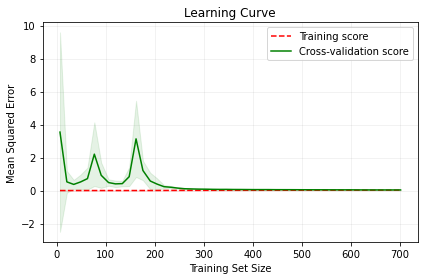

In [190]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(LinearRegression(), 
                                                        Xtrain_std_poly, 
                                                        ytrain,
                                                        # Number of folds in cross-validation
                                                        cv = 10,
                                                        # Evaluation metric
                                                        scoring='neg_mean_squared_error',
                                                        shuffle=True,
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# change sign of mse's
train_scores = np.multiply(-1,train_scores)
test_scores = np.multiply(-1,test_scores)

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="r",  label="Training score")
plt.plot(train_sizes, test_mean, color="g", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="g",alpha = 0.1)

# grid
plt.grid(b=True, which='major', color='#666666', linestyle='-', alpha= 0.1)

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Mean Squared Error"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

### Random Forest

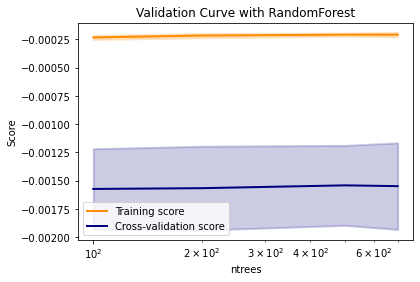

In [188]:
import matplotlib.pyplot as plt
import numpy as np


from sklearn.model_selection import validation_curve



param_range = [100,200,500,700]
train_scores, test_scores = validation_curve(
    RandomForestRegressor(), Xtrain_std, ytrain, param_name="n_estimators", param_range=param_range,
    scoring="neg_mean_squared_error")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with RandomForest")
plt.xlabel("ntrees")
plt.ylabel("Score")
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()


In [152]:
from sklearn.ensemble import RandomForestRegressor 

model = RandomForestRegressor()
mses,models = kfold_validation(Xtrain,ytrain,model)
yhat=models[np.argmin(mses)].predict(Xtest)
np.mean(np.square(yhat-ytest))


0.00099568830723933

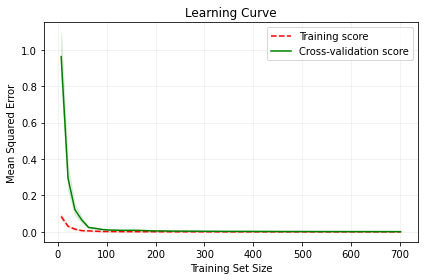

In [153]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(RandomForestRegressor(), 
                                                        Xtrain_std, 
                                                        ytrain,
                                                        # Number of folds in cross-validation
                                                        cv = 10,
                                                        # Evaluation metric
                                                        scoring='neg_mean_squared_error',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# change sign of mse's
train_scores = np.multiply(-1,train_scores)
test_scores = np.multiply(-1,test_scores)

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="r",  label="Training score")
plt.plot(train_sizes, test_mean, color="g", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="g",alpha = 0.1)

# grid
plt.grid(b=True, which='major', color='#666666', linestyle='-', alpha= 0.1)

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Mean Squared Error"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [154]:
from sklearn.svm import SVR

model = SVR()
mses,models = kfold_validation(Xtrain,ytrain,model)
yhat=models[np.argmin(mses)].predict(Xtest)
np.mean(np.square(yhat-ytest))

0.014560411318830142

### SVR

['linear', 'poly', 'rbf', 'sigmoid']


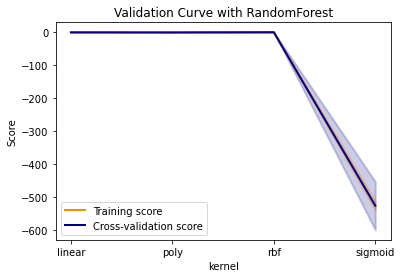

In [195]:
import matplotlib.pyplot as plt
import numpy as np


from sklearn.model_selection import validation_curve



param_range = ['linear','poly','rbf','sigmoid']
train_scores, test_scores = validation_curve(
    SVR(), Xtrain_std, ytrain, param_name="kernel", param_range=param_range,
    scoring="neg_mean_squared_error")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with RandomForest")
plt.xlabel("kernel")
plt.ylabel("Score")
lw = 2
print(param_range)
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()


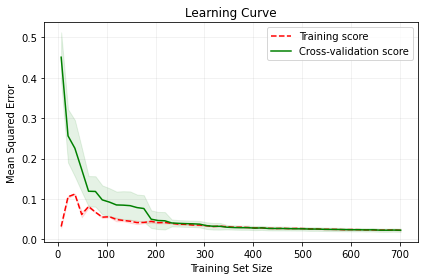

In [155]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(SVR(), 
                                                        Xtrain_std, 
                                                        ytrain,
                                                        # Number of folds in cross-validation
                                                        cv = 10,
                                                        # Evaluation metric
                                                        scoring='neg_mean_squared_error',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# change sign of mse's
train_scores = np.multiply(-1,train_scores)
test_scores = np.multiply(-1,test_scores)

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="r",  label="Training score")
plt.plot(train_sizes, test_mean, color="g", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="g",alpha = 0.1)

# grid
plt.grid(b=True, which='major', color='#666666', linestyle='-', alpha= 0.1)

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Mean Squared Error"), plt.legend(loc="best")
plt.tight_layout()
plt.show()